In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,Input 

In [24]:
data = pd.read_csv('microsoft_cleaned_data.csv')

# Convert Date to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use only the 'High' price for prediction, but you can add more features
# We will use Open, Low, Close, Adj Close, and Volume as input features
#data = data[['Open', 'Low', 'Close', 'Adj Close', 'Volume', 'High']]

data = data[['High']]

# Preprocessing: Scaling the data for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

data

,High
Date,
2010-01-04,31.100000
2010-01-05,31.100000
2010-01-06,31.080000
2010-01-07,30.700001
2010-01-08,30.879999
...,...
2023-11-16,376.350006
2023-11-17,374.369995
2023-11-20,378.869995


In [25]:
# Split the data into training set (2010-2020) and testing set (2021-2023)
train_df = data[:'2020-12-31']
test_df = data['2021-01-01':]

# Select the 'High' price as the target variable for prediction
train_data = train_df[['High']].values
test_data = test_df[['High']].values

print(train_data.shape, test_data.shape)
print(train_df.head())
print(test_df.head())

(2769, 1) (728, 1)
                 High
Date                 
2010-01-04  31.100000
2010-01-05  31.100000
2010-01-06  31.080000
2010-01-07  30.700001
2010-01-08  30.879999
                  High
Date                  
2021-01-04  223.000000
2021-01-05  218.520004
2021-01-06  216.490005
2021-01-07  219.339996
2021-01-08  220.580002


In [27]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # Last 'time_steps' days
        y.append(data[i, 0])  # Predict the 'High' price for the next day
    return np.array(X), np.array(y)

time_steps = 60  # Number of days to look back to predict today's 'High' price
X_train, y_train = create_sequences(train_data, time_steps)

# Reshape X to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Prepare the test data (2021-2023)
total_data = np.concatenate((train_df, test_df), axis=0)  # Use the same columns as train_df and test_df
scaled_total_data = scaler.transform(total_data)
X_test, y_test = create_sequences(scaled_total_data[len(train_data)-time_steps:], time_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


c:\Users\choon\Documents\Chi Ling\BCSCUN\Machine Learning\MLProject\myenv1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [13]:
# Build LSTM model
model = Sequential()

# Input layer 
# The input shape is the number of time steps and the number of features
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layer
model.add(Dense(units=25))

# Output layer (predicting a single value, the 'Close' price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2768, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2768, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 39711.1797 - val_loss: 448.9069
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 37896.9375 - val_loss: 476.2165
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 39503.1953 - val_loss: 504.4492
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 38378.2109 - val_loss: 533.6777
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 37987.5547 - val_loss: 564.0045
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 39263.8789 - val_loss: 595.2366
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 39269.0938 - val_loss: 627.2661
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 37818.9023 - val_loss: 660.3857
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 38152.9570 - val_loss: 694.5508
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 38320.8711 - val_loss: 729.5956
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 37763.9883 - val_loss: 765.7072
Epoch 12/100
1/1 ━━━━━━━━━━━━━

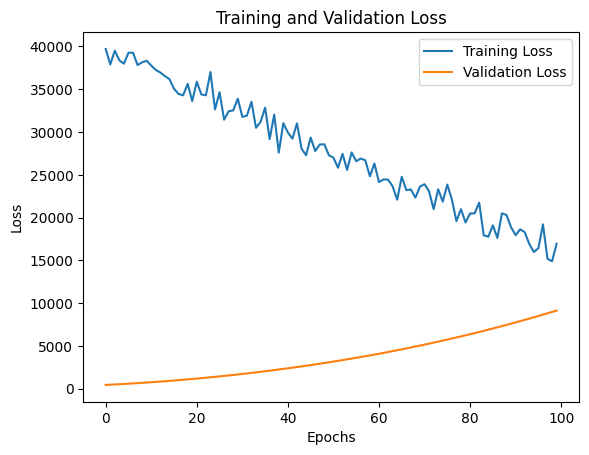

In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# Plotting Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


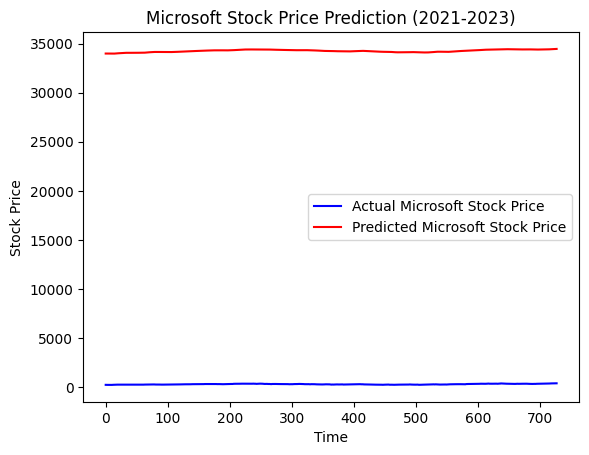

C:\Users\choon\AppData\Local\Temp\ipykernel_23108\990825902.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


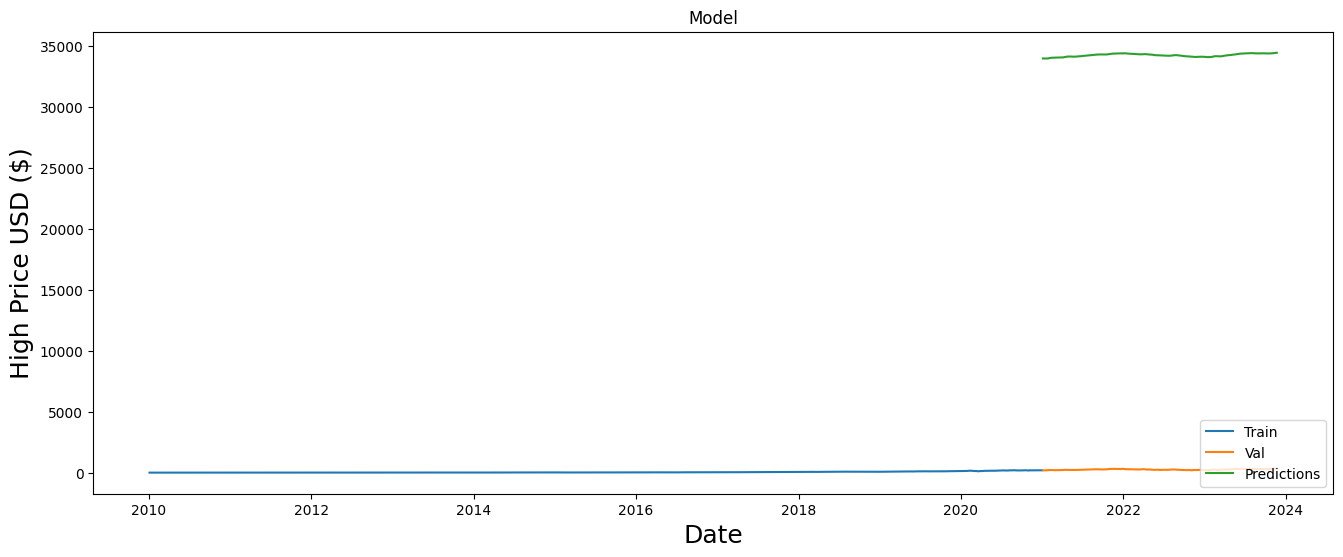

In [30]:
# Predict stock prices for the test set (2021-2023)
predicted_prices = model.predict(X_test)

# Rescale the predicted prices back to original scale
high_scaler = MinMaxScaler(feature_range=(0, 1))
high_scaler.fit(data[['High']])
predicted_prices = high_scaler.inverse_transform(predicted_prices)

# Rescale the actual y_test values back to original scale
y_test_rescaled = high_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs actual prices
plt.plot(y_test_rescaled, color='blue', label='Actual Microsoft Stock Price')
training_data_len = len(train_data)
predictions = predicted_prices

plt.plot(predicted_prices, color='red', label='Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price Prediction (2021-2023)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price USD ($)', fontsize=18)
plt.plot(train['High'])
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()